# Case Study 4 - Decision Trees

__Team Members:__ Amber Clark, Andrew Leppla, Jorge Olmos, Paritosh Rai

# Content
* [Business Understanding](#business-understanding)
    - [Objective](#objective)
    - [Introduction](#introduction)
    - [Methods](#methods)
    - [Results](#results)
* [Data Evaluation](#data-evaluation)
    - [Loading Data](#loading-data) 
    - [Data Summary](#data-summary)
    - [Missing Values](#missing-values)
    - [Feature Removal](#feature-removal)
    - [Exploratory Data Analysis (EDA)](#eda)
    - [Assumptions](#assumptions)
* [Model Preparations](#model-preparations)
    - [Sampling & Scaling Data](#sampling-scaling-data)
    - [Proposed Method](#proposed-metrics)
    - [Evaluation Metrics](#evaluation-metrics)
    - [Feature Selection](#feature-selection)
* [Model Building & Evaluations](#model-building)
    - [Sampling Methodology](#sampling-methodology)
    - [Model](#model)
    - [Performance Analysis](#performance-analysis)
* [Model Interpretability & Explainability](#model-explanation)
    - [Examining Feature Importance](#examining-feature-importance)
* [Conclusion](#conclusion)
    - [Final Model Proposal](#final-model-proposal)
    - [Future Considerations and Model Enhancements](#model-enhancements)
    - [Alternative Modeling Approaches](#alternative-modeling-approaches)

# Business Understanding & Executive Summary <a id='business-understanding'/>

What are we trying to solve for and why is it important?


### Objective <a id='objective'/>

In this case study, the team built a predictive model for determining what factors could indicate whether a company will go bankrupt. The team reviewed the historical data and determined the prime indicators to help an investor determine when to divest from a company ahead of time. 


### Introduction <a id='introduction'/>

Maximizing profits is the prime pursuit of every business. However, the business must have the ability to generate enough revenue and margins to pay debts. Companies' inability to pay off their liabilities in a timely manner can lead to Bankruptcy. "Bankruptcy is a legal proceeding involving a person or business that is unable to repay their outstanding debts" [1]. Bankruptcy is the culmination of multiple issues leading to the economic collapse of a company that certainly warrants detailed analysis to identify the early warning indicators to trigger mitigation sooner.
Bankruptcy is a very complex subject, and the factors leading to Bankruptcy may vary from one business to another. It is critical that models capture this complexity, and nonlinear models are well suited for this task. The team used nonlinear tree-based classification models to predict the response. One method used to execute this methodology was Random Forest Classification. The Random Forest algorithm generates many independent tree models (also known as bagging). The outcomes of each tree model are pooled together to determine the end result (also known as an ensemble model). 
Another ensemble learning technique, XGBoost (Extreme Gradient Boosting), was leveraged to build a robust classifier. In contrast to Random Forest, XGBoost builds a sequential series of dependent tree models to enhance the model performance and generalization (also known as boosting).
This case study aims to build a classification model that predicts whether a company will enter Bankruptcy based on a wide array of collected financial information about those companies. Data came from companies operating in 2007 to 2013. 


### Methods <a id='methods'/>


#### Data Acquisition and Cleanup (Data Wrangling)

The data used in this case study is from the UCI Machine Learning database website [3]. The dataset in its original form was provided as five comma-separated ".arff" files for each of the five years of the forecast period; these were first combined in a single data frame for this cumulative analysis. There are no names, keys, or indicators of any kind for the instances, and the data is purely based on economic indicators with no references to company sizes, types, industries, or vintages. All 64 predictors are continuous numeric variables (some are nonnegative). The 64 column names for the features use alphanumeric keys (from X1 to X64) instead of the full description of the features for simplicity and ease of use with coding. The full names of each feature are included in the Appendix below. The target variable ‘class’ is set to b’1’ for companies that went bankrupt and b’0’ for companies that did not.  For modeling, this was re-coded as target ‘bankrupt’ set at 1 and 0, respectively.   

# TODO: Comeback

The predictors all had different scales ranging in the most extreme from XXXXXX to XXXXXX. The tree-based ensemble methods can handle this raw unscaled data effectively. However, the team decided to normalize the data.
 
 
### Results <a id='results'/>
 

# Data Evaluation/Engineering <a id='data-evaluation'>
    

## Loading Data <a id='loading-data'>

In [1]:
# standard libraries
import pandas as pd
import numpy as np
#import re
import os
from IPython.display import Image
#import sklearn
#import time

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from tabulate import tabulate
from IPython.display import clear_output
import xgboost

# data pre-processing
from scipy.io import arff
#from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.impute._base import _BaseImputer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection._split import BaseShuffleSplit
from sklearn.datasets import load_digits
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# prediction models
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import fbeta_score

# import warnings filter
'''import warnings
warnings.filterwarnings('ignore')
from warnings import simplefilter 
simplefilter(action='ignore', category=FutureWarning)'''

"import warnings\nwarnings.filterwarnings('ignore')\nfrom warnings import simplefilter \nsimplefilter(action='ignore', category=FutureWarning)"

In [2]:
from os import listdir
from os.path import isfile, join

class FilePathManager:
    def __init__(self, local_dir: str):
        self.local_dir = local_dir
    
    def retrieve_full_path(self):
        return os.getcwd()+'/'+self.local_dir

In [3]:
class ARFFLoader:
    df = pd.DataFrame()
    
    def __init__(self, file_path_manager: FilePathManager):
        self.file_path_manager = file_path_manager
    
    def load_data(self):
        files = self.retrieve_files()
        for file in files:
            self.df = pd.concat([self.df, self.load_file(file)])
        self.df=self.df.reset_index(drop=True)
        
    def load_file(self, file_name):
        return pd.DataFrame(arff.loadarff(self.file_path_manager.retrieve_full_path()+'/'+file_name)[0])
 
    def retrieve_files(self):
        full_path = self.file_path_manager.retrieve_full_path()
        return [f for f in os.listdir(full_path) if os.path.isfile(join(full_path, f))]
    
    def get_df(self):
        return self.df;
    
    def size(self):
        return len(self.df)

In [4]:
def clean_df(df: pd.DataFrame):
    df['bankrupt'] = ( df['class'] == df['class'][df.shape[0]-1] ).astype(int)
    df = df.drop('class', axis=1)
    return df;

In [5]:
path_manager = FilePathManager('data')
loader = ARFFLoader(path_manager)
loader.load_data()

In [6]:
df = clean_df(loader.get_df())

Summarize data being used?

Are there missing values?

Which variables are needed and which are not?

What assumptions or conclusions are you drawing about your data?


#### Data Acquisition and Cleanup (Data Wrangling)

The data used in this case study is from the UCI Machine Learning database website [3]. The dataset in its original form was provided as five comma-separated ".arff" files for each of the five years of the forecast period; these were first combined in a single data frame for this cumulative analysis. There are no names, keys, or indicators of any kind for the instances, and the data is purely based on economic indicators with no references to company sizes, types, industries, or vintages. All 64 predictors are continuous numeric variables (some are nonnegative). The 64 column names for the features use alphanumeric keys (from X1 to X64) instead of the full description of the features for simplicity and ease of use with coding. The full names of each feature are included in the Appendix below. The target variable ‘class’ is set to b’1’ for companies that went bankrupt and b’0’ for companies that did not.  For modeling, this was re-coded as target ‘bankrupt’ set at 1 and 0, respectively.   

# TODO: Comeback

The predictors all had different scales ranging in the most extreme from XXXXXX to XXXXXX. The tree-based ensemble methods can handle this raw unscaled data effectively. However, the team decided to normalize the data.

| Variable | Description                                                                                                         |
|----------|---------------------------------------------------------------------------------------------------------------------|
| X1       | net profit / total assets                                                                                           |
| X2       | total liabilities / total assets                                                                                    |
| X3       | working capital / total assets                                                                                      |
| X4       | current assets / short-term liabilities                                                                             |
| X5       | [(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365 |
| X6       | retained earnings / total assets                                                                                    |
| X7       | EBIT / total assets                                                                                                 |
| X8       | book value of equity / total liabilities                                                                            |
| X9       | sales / total assets                                                                                                |
| X10      | equity / total assets                                                                                               |
| X11      | (gross profit + extraordinary items + financial expenses) / total assets                                            |
| X12      | gross profit / short-term liabilities                                                                               |
| X13      | (gross profit + depreciation) / sales                                                                               |
| X14      | (gross profit + interest) / total assets                                                                            |
| X15      | (total liabilities * 365) / (gross profit + depreciation)                                                           |
| X16      | (gross profit + depreciation) / total liabilities                                                                   |
| X17      | total assets / total liabilities                                                                                    |
| X18      | gross profit / total assets                                                                                         |
| X19      | gross profit / sales                                                                                                |
| X20      | (inventory * 365) / sales                                                                                           |
| X21      | sales (n) / sales (n-1)                                                                                             |
| X22      | profit on operating activities / total assets                                                                       |
| X23      | net profit / sales                                                                                                  |
| X24      | gross profit (in 3 years) / total assets                                                                            |
| X25      | (equity - share capital) / total assets                                                                             |
| X26      | (net profit + depreciation) / total liabilities                                                                     |
| X27      | profit on operating activities / financial expenses                                                                 |
| X28      | working capital / fixed assets                                                                                      |
| X29      | logarithm of total assets                                                                                           |
| X30      | (total liabilities - cash) / sales                                                                                  |
| X31      | (gross profit + interest) / sales                                                                                   |
| X32      | (current liabilities * 365) / cost of products sold                                                                 |
| X33      | operating expenses / short-term liabilities                                                                         |
| X34      | operating expenses / total liabilities                                                                              |
| X35      | profit on sales / total assets                                                                                      |
| X36      | total sales / total assets                                                                                          |
| X37      | (current assets - inventories) / long-term liabilities                                                              |
| X38      | constant capital / total assets                                                                                     |
| X39      | profit on sales / sales                                                                                             |
| X40      | (current assets - inventory - receivables) / short-term liabilities                                                 |
| X41      | total liabilities / ((profit on operating activities + depreciation) * (12/365))                                    |
| X42      | profit on operating activities / sales                                                                              |
| X43      | rotation receivables + inventory turnover in days                                                                   |
| X44      | (receivables * 365) / sales                                                                                         |
| X45      | net profit / inventory                                                                                              |
| X46      | (current assets - inventory) / short-term liabilities                                                               |
| X47      | (inventory * 365) / cost of products sold                                                                           |
| X48      | EBITDA (profit on operating activities - depreciation) / total assets                                               |
| X49      | EBITDA (profit on operating activities - depreciation) / sales                                                      |
| X50      | current assets / total liabilities                                                                                  |
| X51      | short-term liabilities / total assets                                                                               |
| X52      | (short-term liabilities * 365) / cost of products sold)                                                             |
| X53      | equity / fixed assets                                                                                               |
| X54      | constant capital / fixed assets                                                                                     |
| X55      | working capital                                                                                                     |
| X56      | (sales - cost of products sold) / sales                                                                             |
| X57      | (current assets - inventory - short-term liabilities) / (sales - gross profit - depreciation)                       |
| X58      | total costs /total sales                                                                                            |
| X59      | long-term liabilities / equity                                                                                      |
| X60      | sales / inventory                                                                                                   |
| X61      | sales / receivables                                                                                                 |
| X62      | (short-term liabilities *365) / sales                                                                               |
| X63      | sales / short-term liabilities                                                                                      |
| X64      | sales / fixed assets                                                                                                |

## Missing Values <a id='missing-values'>
    
Many features had missing values, but there were two features in particular with large amounts of missing data: Attr37 = (current assets - inventories) / (long-term liabilities) with 46% missing data, and Attr27 = (profit on operating activities) / (financial expenses) with 14% missing data.  Attr27 had significantly more missing values for bankrupt (orange, 1) vs. not bankrupt (blue, 0).  This could be exploited for predicting bankruptcy.    

In [7]:
missing_0 = df[df['bankrupt']==0].isnull().sum()
pct_missing_0 = missing_0/missing_0.sum()
missing_1 = df[df['bankrupt']==1].isnull().sum()
pct_missing_1 = missing_1/missing_1.sum()
pct_missing_by_bankruptcy = pd.concat([pct_missing_0, pct_missing_1], axis=1)
pct_missing_by_bankruptcy.columns = ['0','1']

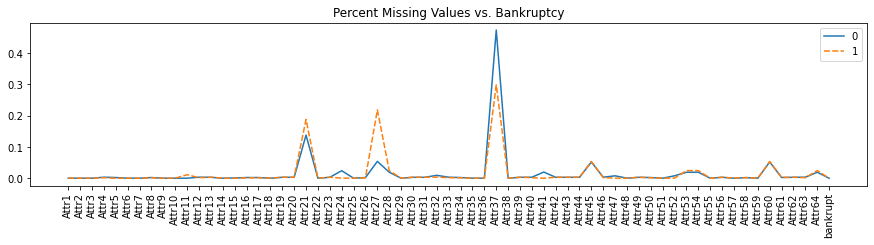

In [8]:
plt.figure(figsize=(15,3))
sns.lineplot(data = pct_missing_by_bankruptcy)
plt.xticks(rotation=90)
plt.title('Percent Missing Values vs. Bankruptcy')
plt.show()

SKLearn’s RandomForestClassifier cannot handle missing values automatically.  Therefore, all missing values were initially replaced simply with the median value for each feature from the training data.  The median (vs. the mean) was used because most features were highly skewed and had extreme outliers (refer to Box plots in the Appendix).

However, missing values in financial data are typically not Missing at Random; data reporting in finance is highly regulated with oversight from auditors.  Finance data tend to be missing because they are not able to be reported for specific reasons.  For example, most of the features are ratios, so if the denominator = 0 that would result in dividing by zero which is not reportable.  Therefore, this median imputation method for handling missing data may not be appropriate. 

The XGBoost algorithm was able to handle missing values automatically.  From the xgboost documentation,  "XGBoost supports missing values by default. In tree algorithms, branch directions for missing values are learned during training."

An Iterative Imputer was also used as a more sophisticated, albeit more computationally expensive way to replace missing values.  Per the sklearn documentation, it “models each feature with missing values as a function of other features” using regression.  It starts with imputing the feature with the least amount of missing values, and it builds up iteratively to the feature with the most missing values.  This method gave the best overall model results for both Random Forest and XGBoost.  

Note: All imputation and normalization were carried out post-splitting of data into training and test data independent of each other to prevent data leakage between training and test data set. 


## TODO: Feature Removal <a id='feature-removal'>

## Exploratory Data Analysis (EDA) <a id='eda'>

### Data Imbalance

Looking at the distribution of the target outcome (i.e., whether a company went bankrupt or not), the data is heavily imbalanced. As expected, the proportion of companies that went bankrupt is significantly less compared to the ones that did not.


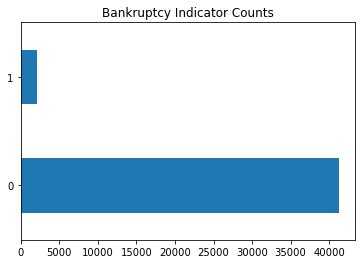

In [9]:
df['bankrupt'].value_counts().plot(kind='barh', title='Bankruptcy Indicator Counts');

The team decided to use stratified splitting technique during the train-test split process to ensure the proportion of target variable remains same in both the train and test data sets.

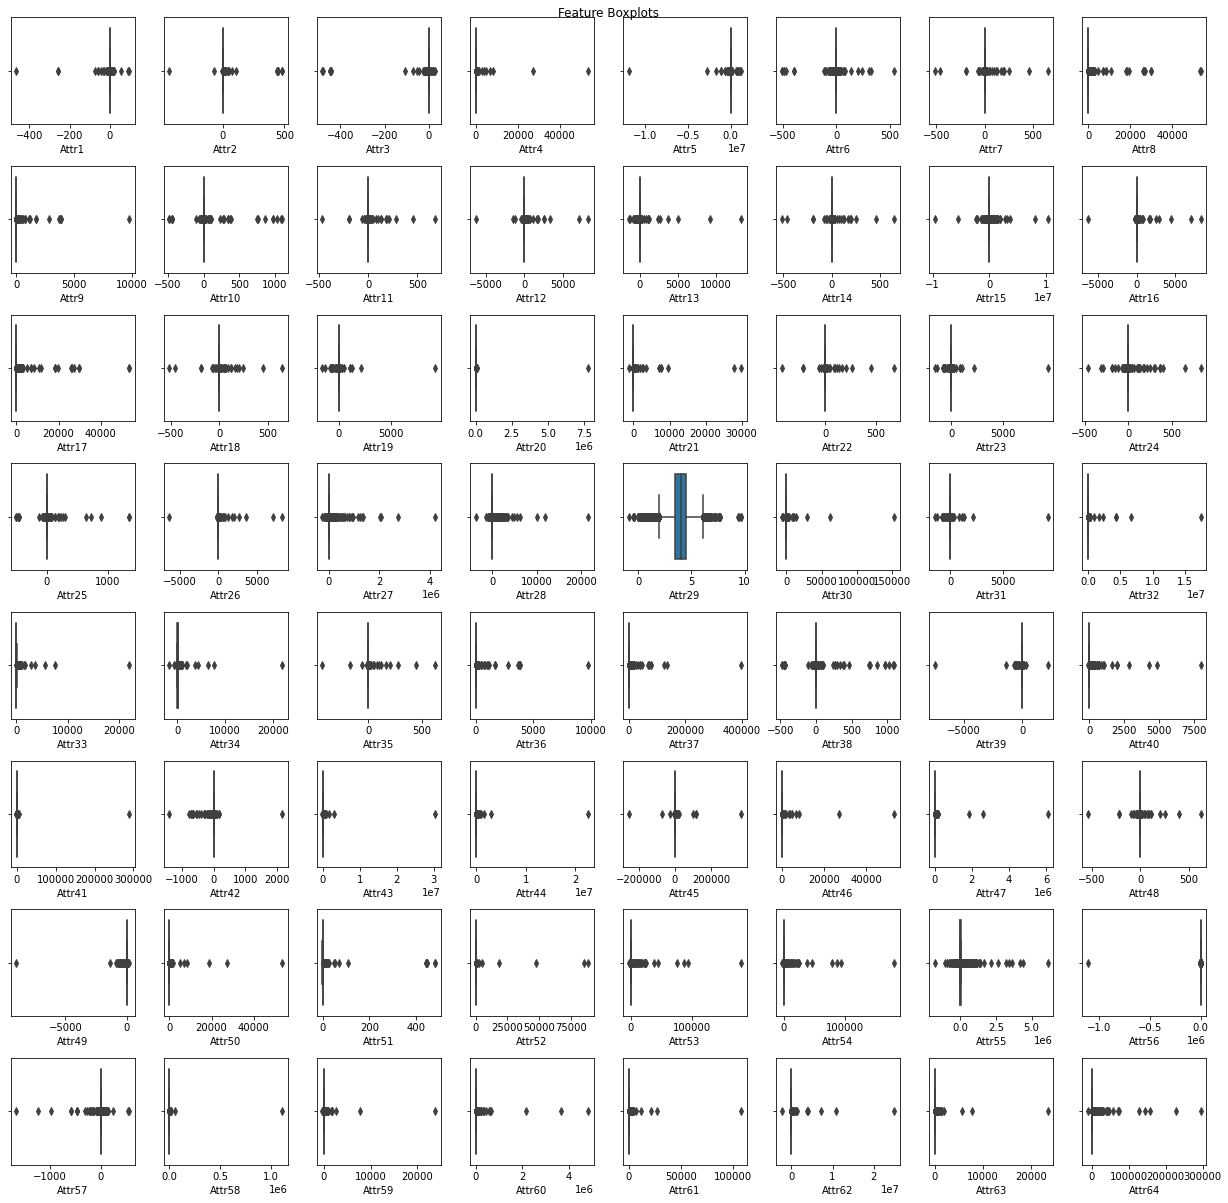

In [10]:
features = df.drop('bankrupt', axis=1).columns
fig, axes = plt.subplots(8, 8, figsize=(17, 17))
fig.suptitle('Feature Boxplots')
for i,j in zip(features, range(64)):
    sns.boxplot(ax = axes[int(j/8), j%8], x = df.drop('bankrupt', axis=1)[i])

fig.tight_layout()

# Model Preparations <a id='model-preparations'/>

## Proposed Method <a id='proposed-metrics' />

Which methods are you proposing to utilize to solve the problem?

Why is this method appropriate given the business objective? 

TODO: __How will you determine if your approach is useful (or how will you differentiate which approach is more useful than another)?__

Bankruptcy is a very complex subject, and the factors leading to Bankruptcy may vary from one business to another. It is critical that models capture this complexity, and nonlinear models are well suited for this task. The team used nonlinear tree-based classification models to predict the response. One method used to execute this methodology was Random Forest Classification. The Random Forest algorithm generates many independent tree models (also known as bagging). The outcomes of each tree model are pooled together to determine the end result (also known as an ensemble model). 

Another ensemble learning technique, XGBoost (Extreme Gradient Boosting), was leveraged to build a robust classifier. In contrast to Random Forest, XGBoost builds a sequential series of dependent tree models to enhance the model performance and generalization (also known as boosting).


This case study aims to build a classification model that predicts whether a company will enter Bankruptcy based on a wide array of collected financial information about those companies. Data came from companies operating in 2007 to 2013. 


## TODO: Sampling & Scaling Data

The dataset was first split into training and test sets with 30% of the data reserved for the test set. The target class is heavily imbalanced as discussed above, with only about 5% of the outcomes being bankruptcy. So, the test/train split was done using the stratified option to maintain the ratio of outcomes. 

## Evaluation Metrics <a id='evaluation-metrics' />

More specifically, what evaluation metrics are most useful given that the problem is a binary-classification one (ex., Accuracy, F1-score, Precision, Recall, AUC, etc.)?

The metric used to evaluate model performance were the total costs of false negatives (FN) and false positives (FP).       

A False Negative (FN) is "Incorrectly predicting Bankruptcy to be Solvency" which is related to Recall.  The cost of a False Negative is assumed to be a 100% loss (unless the investor has some protections or agreements in place).

A False Positive (FP) is "Incorrectly predicting Solvency to be Bankruptcy" which is related to Precision.  The team assumes a False Positive occurs for a company that is already under significant financial duress, likely with investor losses of approximately 50% or more.  An investor would likely act on this prediction by selling some or all of the asset to cut their losses.  The company in fact won’t go bankrupt, and the future outcome for investors is uncertain and could vary widely: it may suffer further losses, recover some or all of its losses, or return a gain longer term.

The total costs (losses) to investors were calculated as follows:

__Total  investor costs (losses) = (100%*FP + 50%*FN)__

To directly compare training and test sets, the total investor losses were normalized as “% total investor loss” by dividing by the number of companies (instances) in the training and test sets, respectively.           

In [11]:
cost_matrix = np.array([[0,0.5],[1,0]])
cost_matrix

array([[0. , 0.5],
       [1. , 0. ]])

# Model Building & Evaluations <a id='model-building'/>

In this case, your primary task is to build both a Random Forest and XGBoost model to accurately predict bankruptcy and will involve the following steps:

- Specify your sampling methodology
- Setup your models - highlighting any important parameters
- Analyze each model's performance - referencing your chosen evaluation metric (including supplemental visuals and analysis where appropriate)

The team’s objective was to minimize the Total investor costs (losses) without overfitting the model.  Overfitting is defined as the training set outperforming the test set (lower losses for the training set)
The team assumes investors are well-diversified and don’t have more than 1-5% of their portfolio in any single company. 

The purpose of this modeling exercise is to predict companies that may go bankrupt so that the business can make relevant divestiture decisions or trigger other mitigation strategies to minimize the losses. 


## Sampling Methodology

The dataset was first split into training and test sets with 30% of the data reserved for the test set. The target class is heavily imbalanced as discussed above, with only about 5% of the outcomes being bankruptcy. So, the test/train split was done using the stratified option to maintain the ratio of outcomes. 

## Modeling

In [12]:
from abc import ABC, abstractmethod

class BaseImputer:
    @abstractmethod
    def fit(self, X, y=None):
        pass
    
    @abstractmethod
    def transform(self, X):
        pass

class BaseModel:
    @abstractmethod
    def fit(self, X, y, sample_weight=None):
        pass
    
    @abstractmethod
    def predict(self, X):
        pass

In [13]:
class XGBModel:
    _model = None
    
    def __init__(self, params, num_round: int = 100):
        self._params = params
        self._num_round = num_round
        
    def fit(self, X, y, sample_weight=None):
        dtrain = xgb.DMatrix(X, label = y)
        self._model = xgb.train(self._params, dtrain)
        
    def predict(self, X):
        dtest = xgb.DMatrix(X)
        return self._model.predict(dtest)
        

In [14]:
class Modeling:
    _X_train_fitted = None
    _X_test_fitted = None
    _y_train = None
    _y_test = None
    _y_preds = None
    
    def __init__(self, data: pd.DataFrame, 
                 target_name: str, 
                 shuffle_splitter: BaseShuffleSplit, 
                 imputer: BaseImputer, 
                 model: BaseModel, scaler = None):
        self._data = data
        self._target_name = target_name
        self._shuffle_splitter = shuffle_splitter
        self._imputer = imputer
        self._model = model
        self._X, self._y = self._split_data()
        self._scaler = scaler
        
    @property
    def X(self):
        return self._X
    
    @property
    def y(self):
        return self._y

    @property
    def model(self):
        return self._model
    
    @model.setter
    def model(self, model):
        self._model = model
     
    @property
    def X_train(self):
        return self._X_train_fitted
    
    @property
    def X_test(self):
        return self._X_test_fitted
    
    @property
    def y_train(self):
        return self._y_train
    
    @property
    def y_test(self):
        return self._y_test
    
    @property
    def y_preds(self):
        return self._y_preds
    
    def _split_data(self):
        X = self._data.copy()
        return X.drop([self._target_name], axis=1) , X[self._target_name]
    
    def _shuffle_split(self):
        X = self.X
        y = self.y
        for train_index, test_index in self._shuffle_splitter.split(X,y):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y[train_index], y[test_index]
        return X_train, X_test, y_train, y_test
    
    def _fit_imputer(self, train):
        if self._imputer is not None:
            self._imputer.fit(train)
    
    def _fit_scaler(self, train):
        if self._scaler is not None:
            self._scaler.fit(train)
    
    def _impute_data(self, X: pd.DataFrame):
        if self._imputer is not None:
            return pd.DataFrame(self._imputer.transform(X), columns = self.X.columns, index = X.index)
        return X
    
    def _scale_data(self, X: pd.DataFrame):
        if self._scaler is not None:
            X = pd.DataFrame(self._scaler.transform(X), columns = self._X.columns)
        return X
    
    def prepare(self):
        X_train, X_test, y_train, y_test = self._shuffle_split()   
        self._fit_imputer(X_train)
        X_train = self._impute_data(X_train)
        X_test = self._impute_data(X_test)
        self._fit_scaler(X_train)
        self._X_train_fitted = self._scale_data(X_train)
        self._X_test_fitted = self._scale_data(X_test)
        self._y_train = y_train
        self._y_test = y_test
        
    def prepare_and_train(self):
        self.prepare()
        return self.train()
        
    def train(self):
        self._model.fit(self.X_train, self.y_train)
        self._y_preds = self._model.predict(self.X_train)
        
        return self.metrics(self.y_train, self.y_preds)
        
    def test(self):
        return self.metrics(self.y_test, self._model.predict(self.X_test))
       
    @abstractmethod
    def metrics(self, y_true = None, y_pred = None):
        pass
        

In [15]:
class ClassificationModeling(Modeling):
    def __init__(self, 
                 data: pd.DataFrame, 
                 target_name: str, 
                 shuffle_splitter: BaseShuffleSplit, 
                 imputer: BaseImputer, 
                 model: BaseModel, 
                 scaler = None, 
                 beta: int = 1, 
                 classification: str = 'binary'):
        super().__init__(data, target_name, shuffle_splitter, imputer, model, scaler)
        self.beta = beta
        self.classification = classification
    
    def metrics(self, y_true = None, y_pred = None):
        if y_true is None and y_pred is None:
            y_true = self.y_train
            y_pred = self.y_preds
        if type(y_pred[0]) is np.int32: # RandomForest, xbg binary:hinge, xbg multi:softmax
            return ({'matrix': confusion_matrix(y_true, y_pred), 
                'accuracy': accuracy_score(y_true, y_pred), 
                'precision': precision_score(y_true, y_pred, average=self.classification), 
                'recall': recall_score(y_true, y_pred, average=self.classification),
                 'f1': f1_score(y_true, y_pred),
                'f{}'.format(self.beta) : fbeta_score(y_true, y_pred, average=self.classification, beta=self.beta) } )
        else: # to handle xbg binary:logistic with class_weights
            y_pred = pd.Series( (y_pred>0.5).astype(int), index=y_true.index) 
            return ({'matrix': confusion_matrix(y_true, y_pred), 
                'accuracy': accuracy_score(y_true, y_pred), 
                'precision': precision_score(y_true, y_pred, average=self.classification), 
                'recall': recall_score(y_true, y_pred, average=self.classification),
                 'f1': f1_score(y_true, y_pred),
                'f{}'.format(self.beta) : fbeta_score(y_true, y_pred, average=self.classification, beta=self.beta) } )
        

In [16]:
classifier = ClassificationModeling(clean_df(loader.get_df()),'bankrupt',
                           StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=12343),
                           IterativeImputer(missing_values=np.nan, random_state=1234),
                           None,
                           StandardScaler(), beta=2)
classifier.prepare()

C:\Users\allep\anaconda3\envs\MyEnv3_7\lib\site-packages\sklearn\impute\_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


### Random Forest Model

#### Metrics vs. Max Tree Depth

##### No Class Weights

In [18]:
'''rf_no_class_wt = pd.DataFrame()
for i in range(4,21):
    classifier.model = RandomForestClassifier(random_state=0, class_weight=None, max_depth = i)
    train_out = classifier.train()
    test_out = classifier.test()
    rf_no_class_wt = rf_no_class_wt.append({'max_depth': classifier.model.max_depth,
                    'accuracy_train': train_out['accuracy'],
                    'accuracy_test': test_out['accuracy'],
                    'f1_train': train_out['f1'],          
                    'f1_test': test_out['f1'],
                    'f2_train': train_out['f2'],          
                    'f2_test': test_out['f2'],           
                    '%_invest_loss_train': 100*np.sum(cost_matrix*train_out['matrix'])/np.sum(train_out['matrix']),
                    '%_invest_loss_test': 100*np.sum(cost_matrix*test_out['matrix'])/np.sum(test_out['matrix'])}, 
                    ignore_index = True)
    print("max_depth =",i,"complete")
clear_output()
rf_no_class_wt'''

,%_invest_loss_test,%_invest_loss_train,accuracy_test,accuracy_train,f1_test,f1_train,f2_test,f2_train,max_depth
0,4.753494,4.769114,0.952465,0.952309,0.025197,0.020284,0.015898,0.012775,4.0
1,4.630625,4.637462,0.953694,0.953625,0.073733,0.072416,0.047393,0.046523,5.0
2,4.523115,4.443274,0.954769,0.955567,0.114286,0.144487,0.074627,0.095477,6.0
3,4.039318,3.692855,0.959607,0.963071,0.277473,0.378738,0.193561,0.275895,7.0
4,3.962525,3.488793,0.960375,0.965112,0.300813,0.432548,0.211913,0.322684,8.0
5,3.801259,3.107001,0.961987,0.968930,0.347826,0.524194,0.250000,0.407779,9.0
6,3.586239,2.800908,0.964061,0.971991,0.407595,0.590274,0.301385,0.473798,10.0
7,3.567040,2.537603,0.964214,0.974624,0.413098,0.642559,0.306542,0.529088,11.0
8,3.432652,2.323668,0.965443,0.976763,0.448529,0.682268,0.339266,0.573027,12.0
9,3.375058,1.978080,0.965904,0.980219,0.463768,0.741728,0.354374,0.642209,13.0


##### Rebalanced 

In [31]:
rf_rebalanced = pd.DataFrame()
for i in range(5,21):
    classifier.model = RandomForestClassifier(random_state=0, class_weight='balanced', max_depth = i)
    train_out = classifier.train()
    test_out = classifier.test()
    rf_rebalanced = rf_rebalanced.append({'max_depth': classifier.model.max_depth,
                    'accuracy_train': train_out['accuracy'],
                    'accuracy_test': test_out['accuracy'],
                    'f1_train': train_out['f1'],          
                    'f1_test': test_out['f1'],
                    'f2_train': train_out['f2'],          
                    'f2_test': test_out['f2'],           
                    '%_invest_loss_train': 100*np.sum(cost_matrix*train_out['matrix'])/np.sum(train_out['matrix']),
                    '%_invest_loss_test': 100*np.sum(cost_matrix*test_out['matrix'])/np.sum(test_out['matrix'])}, 
                    ignore_index = True)
    print("max_depth =",i,"complete")
clear_output()
rf_rebalanced

,max_depth,accuracy_train,accuracy_test,f1_train,f1_test,f2_train,f2_test,%_invest_loss_train,%_invest_loss_test
0,5.0,0.793536,0.783443,0.264682,0.244373,0.436818,0.406200,10.874502,11.484411
1,6.0,0.828128,0.816080,0.308894,0.273582,0.488366,0.435496,9.082382,9.871755
2,7.0,0.869335,0.850637,0.376962,0.303117,0.557878,0.452697,6.966067,8.251421
3,8.0,0.896521,0.874597,0.437164,0.325485,0.611846,0.457927,5.573841,7.164798
4,9.0,0.918968,0.896099,0.504428,0.349832,0.669338,0.459364,4.398841,6.204884
5,10.0,0.941875,0.917371,0.594023,0.392777,0.738961,0.476321,3.189283,5.202734
6,11.0,0.958497,0.931347,0.676915,0.411842,0.796263,0.460159,2.310503,4.638304
7,12.0,0.967844,0.939794,0.734005,0.422680,0.835710,0.443038,1.798703,4.315773
8,13.0,0.976566,0.945938,0.795167,0.434084,0.878241,0.432000,1.306652,4.073875
9,14.0,0.982786,0.950392,0.842517,0.435315,0.906910,0.411570,0.967646,3.931808


### Extreme Gradient Boosting

#### Metrics vs. Max Tree Depth

##### No Class Weights

In [ ]:
'''xgb_no_class_wt = pd.DataFrame()
for i in range(2,21):
    params = {
    'max_depth': i,
    'objective': 'multi:softmax',
    'eval_metric': 'logloss',
    'num_class': 2,
    'eta': 0.3,
    }
    classifier.model = XGBModel(params) #num_round
    train_out = classifier.train()
    test_out = classifier.test()
    xgb_no_class_wt = xgb_no_class_wt.append({'max_depth': i,
                    'accuracy_train': train_out['accuracy'],
                    'accuracy_test': test_out['accuracy'],
                    'f1_train': train_out['f1'],          
                    'f1_test': test_out['f1'],
                    'f2_train': train_out['f2'],            
                    'f2_test': test_out['f2'], 
                    '%_invest_loss_train': 100*np.sum(cost_matrix*train_out['matrix'])/np.sum(train_out['matrix']),
                    '%_invest_loss_test': 100*np.sum(cost_matrix*test_out['matrix'])/np.sum(test_out['matrix'])}, 
                    ignore_index = True)
    print("max_depth =",i,"complete")
clear_output()
xgb_no_class_wt'''

##### Rebalanced 

In [23]:
xgb_rebalanced = pd.DataFrame()
for i in range(2,21):
    params = {
    'max_depth': i,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    #'num_class': 2,
    'eta': 0.3,
    'scale_pos_weight': 19.758 
    }
    classifier.model = XGBModel(params)
    train_out = classifier.train()
    test_out = classifier.test()
    xgb_rebalanced = xgb_rebalanced.append({'max_depth': i,
                    'accuracy_train': train_out['accuracy'],
                    'accuracy_test': test_out['accuracy'],
                    'f1_train': train_out['f1'],          
                    'f1_test': test_out['f1'],                        
                    'f2_train': train_out['f2'],            
                    'f2_test': test_out['f2'], 
                    '%_invest_loss_train': 100*np.sum(cost_matrix*train_out['matrix'])/np.sum(train_out['matrix']),
                    '%_invest_loss_test': 100*np.sum(cost_matrix*test_out['matrix'])/np.sum(test_out['matrix'])}, 
                    ignore_index = True)
    print("max_depth =",i,"complete")
clear_output()
xgb_rebalanced

,max_depth,accuracy_train,accuracy_test,f1_train,f1_test,f2_train,f2_test,%_invest_loss_train,%_invest_loss_test
0,2.0,0.795741,0.787590,0.265388,0.251623,0.436526,0.416891,10.777408,11.242513
1,3.0,0.810651,0.801106,0.293504,0.275322,0.476665,0.450962,9.910147,10.463063
2,4.0,0.828457,0.819920,0.326093,0.298534,0.519957,0.477603,8.911233,9.495469
3,5.0,0.847941,0.832821,0.361349,0.309546,0.562102,0.484704,7.861304,8.892643
4,6.0,0.885594,0.867148,0.435531,0.351088,0.635545,0.514625,5.922720,7.253110
5,7.0,0.904815,0.884810,0.489407,0.379139,0.689141,0.532930,4.887602,6.408386
6,8.0,0.915775,0.892720,0.524615,0.388621,0.722251,0.532885,4.296811,6.066656
7,9.0,0.939966,0.912533,0.612739,0.425618,0.792683,0.546066,3.036237,5.160498
8,10.0,0.955633,0.922977,0.683122,0.446773,0.840273,0.548186,2.236448,4.703579
9,11.0,0.968765,0.935724,0.753826,0.477854,0.880926,0.549656,1.579831,4.150668


## Model's Performance Analysis <a id='performance-analysis'/>

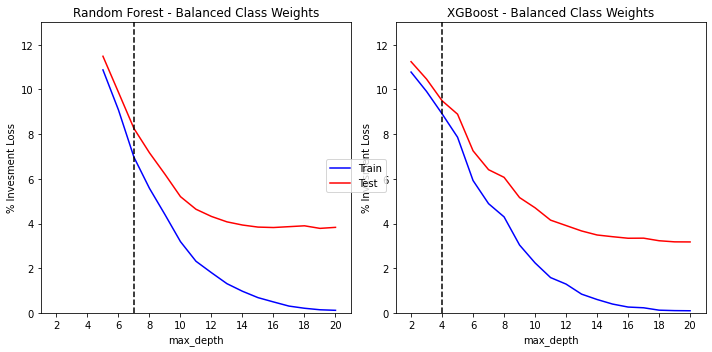

In [37]:
from matplotlib.ticker import MaxNLocator

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
#fig.suptitle('Tuning max_depth')

sns.lineplot(ax=axes[0], data=rf_rebalanced, x='max_depth', y='%_invest_loss_train', color='blue')
sns.lineplot(ax=axes[0], data=rf_rebalanced, x='max_depth', y='%_invest_loss_test', color='red')
axes[0].xaxis.set_major_locator(MaxNLocator(integer=True))
axes[0].set_xlim(left=1, right=21)
axes[0].set_ylim(bottom=0, top=13)
axes[0].set_ylabel('% Invesment Loss')
axes[0].set_title('Random Forest - Balanced Class Weights')
axes[0].axvline(7,color='black',ls='--') 

sns.lineplot(ax=axes[1], data=xgb_rebalanced, x='max_depth', y='%_invest_loss_train', color='blue')
sns.lineplot(ax=axes[1], data=xgb_rebalanced, x='max_depth', y='%_invest_loss_test', color='red')
axes[1].xaxis.set_major_locator(MaxNLocator(integer=True))
axes[1].set_xlim(left=1, right=21)
axes[1].set_ylim(bottom=0, top=13)
axes[1].set_ylabel('% Invesment Loss')
axes[1].set_title('XGBoost - Balanced Class Weights')
axes[1].axvline(4,color='black',ls='--') 

fig.legend(['Train','Test'], loc='center')
fig.tight_layout() 
plt.show()

In [ ]:
'''from matplotlib.ticker import MaxNLocator

fig, axes = plt.subplots(2, 2, figsize=(10, 7))
#fig.suptitle('Tuning max_depth')

sns.lineplot(ax=axes[0,0], data=rf_no_class_wt, x='max_depth', y='%_invest_loss_train', color='blue')
sns.lineplot(ax=axes[0,0], data=rf_no_class_wt, x='max_depth', y='%_invest_loss_test', color='red')
axes[0,0].xaxis.set_major_locator(MaxNLocator(integer=True))
axes[0,0].set_xlim(left=1, right=21)
axes[0,0].set_ylim(bottom=0, top=13)
axes[0,0].set_ylabel('% Invesment Loss')
axes[0,0].set_title('Random Forest - No Class Weights')
axes[0,0].axvline(7,color='black',ls='--') 

sns.lineplot(ax=axes[0,1], data=rf_rebalanced, x='max_depth', y='%_invest_loss_train', color='blue')
sns.lineplot(ax=axes[0,1], data=rf_rebalanced, x='max_depth', y='%_invest_loss_test', color='red')
axes[0,1].xaxis.set_major_locator(MaxNLocator(integer=True))
axes[0,1].set_xlim(left=1, right=21)
axes[0,1].set_ylim(bottom=0, top=13)
axes[0,1].set_ylabel('% Invesment Loss')
axes[0,1].set_title('Random Forest - Balanced Class Weights')
axes[0,1].axvline(7,color='black',ls='--') 

sns.lineplot(ax=axes[1,0], data=xgb_no_class_wt, x='max_depth', y='%_invest_loss_train', color='blue')
sns.lineplot(ax=axes[1,0], data=xgb_no_class_wt, x='max_depth', y='%_invest_loss_test', color='red')
axes[1,0].xaxis.set_major_locator(MaxNLocator(integer=True))
axes[1,0].set_xlim(left=1, right=21)
axes[1,0].set_ylim(bottom=0, top=13)
axes[1,0].set_ylabel('% Invesment Loss')
axes[1,0].set_title('XGBoost - No Class Weights')
axes[1,0].axvline(4,color='black',ls='--') 

sns.lineplot(ax=axes[1,1], data=xgb_rebalanced, x='max_depth', y='%_invest_loss_train', color='blue')
sns.lineplot(ax=axes[1,1], data=xgb_rebalanced, x='max_depth', y='%_invest_loss_test', color='red')
axes[1,1].xaxis.set_major_locator(MaxNLocator(integer=True))
axes[1,1].set_xlim(left=1, right=21)
axes[1,1].set_ylim(bottom=0, top=13)
axes[1,1].set_ylabel('% Invesment Loss')
axes[1,1].set_title('XGBoost - Balanced Class Weights')
axes[1,1].axvline(4,color='black',ls='--') 

fig.legend(['Train','Test'], loc='center')
fig.tight_layout() 
plt.show()'''

### Model results
Per the graphs above, rebalancing the classes decreases the overall performance of the models for both Random Forest and XGBoost.  "XGBoost - No Class Weights" whht max_depth = 4 gives the best (minimum) % Investor Loss without significantly overfitting the training set.   

### Eta vs. Metrics

In [38]:
xgb_rebalanced_eta = pd.DataFrame()
eta = 0.01
for i in range(0,10):
    params = {
    'max_depth': 4,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': eta,
    'scale_pos_weight': 19.758 
    }
    classifier.model = XGBModel(params) #num_round
    train_out = classifier.train()
    test_out = classifier.test()
    xgb_rebalanced_eta = xgb_rebalanced_eta.append({'eta': round(eta,2),
                    'accuracy_train': train_out['accuracy'],
                    'accuracy_test': test_out['accuracy'],
                    'f1_train': train_out['f1'],          
                    'f1_test': test_out['f1'],                                  
                    'f2_train': train_out['f2'],            
                    'f2_test': test_out['f2'], 
                    '%_invest_loss_train': 100*np.sum(cost_matrix*train_out['matrix'])/np.sum(train_out['matrix']),
                    '%_invest_loss_test': 100*np.sum(cost_matrix*test_out['matrix'])/np.sum(test_out['matrix'])}, 
                    ignore_index = True)
    print("eta =",round(eta,2),"complete")
    eta = eta+0.1
clear_output()
xgb_rebalanced_eta

,eta,accuracy_train,accuracy_test,f1_train,f1_test,f2_train,f2_test,%_invest_loss_train,%_invest_loss_test
0,0.01,0.760853,0.756259,0.250310,0.240306,0.430631,0.414260,12.370405,12.667025
1,0.11,0.797551,0.789817,0.281341,0.264445,0.464829,0.439129,10.550308,11.027492
2,0.21,0.818550,0.808478,0.310789,0.284977,0.501574,0.462842,9.436198,10.075257
3,0.31,0.825659,0.814237,0.324793,0.292483,0.520552,0.471698,9.029721,9.775764
4,0.41,0.843432,0.832591,0.349515,0.315327,0.545921,0.495558,8.134483,8.850407
5,0.51,0.853174,0.838197,0.368577,0.318344,0.568212,0.494771,7.607873,8.608509
6,0.61,0.859165,0.843880,0.380663,0.323461,0.581807,0.497339,7.286970,8.347412
7,0.71,0.860020,0.847182,0.383176,0.324049,0.585186,0.494301,7.234309,8.216864
8,0.81,0.863410,0.849946,0.390781,0.328984,0.593984,0.499687,7.048349,8.070957
9,0.91,0.861271,0.842267,0.384222,0.312584,0.585121,0.479565,7.181648,8.500998


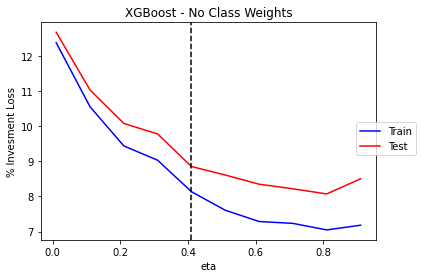

In [46]:
fig, axes = plt.subplots(1, 1, figsize=(6, 4))

sns.lineplot(data=xgb_rebalanced_eta, x='eta', y='%_invest_loss_train', color='blue')
sns.lineplot(data=xgb_rebalanced_eta, x='eta', y='%_invest_loss_test', color='red')
#plt.xaxis.set_major_locator(MaxNLocator(integer=True))
#axes[0].set_ylim(bottom=0, top=0.13)
plt.ylabel('% Invesment Loss')
plt.title('XGBoost - No Class Weights')
plt.axvline(0.41,color='black',ls='--') 

fig.legend(['Train','Test'], loc='right')
plt.show()

#### Final Model "XGBoost - No Class Weights"
The best model run with was "XGBoost - No Class Weights" with max_depth = 4 and eta = 0.3.  This had the lowest % Investment Losses without overfitting the training set vs. the test set.  

In [47]:
params = {
'max_depth': 4,
'objective': 'binary:logistic',
'eval_metric': 'logloss',
'eta': 0.4,
'scale_pos_weight': 19.758 
}
classifier.model = XGBModel(params)
train_out = classifier.train()
test_out = classifier.test()

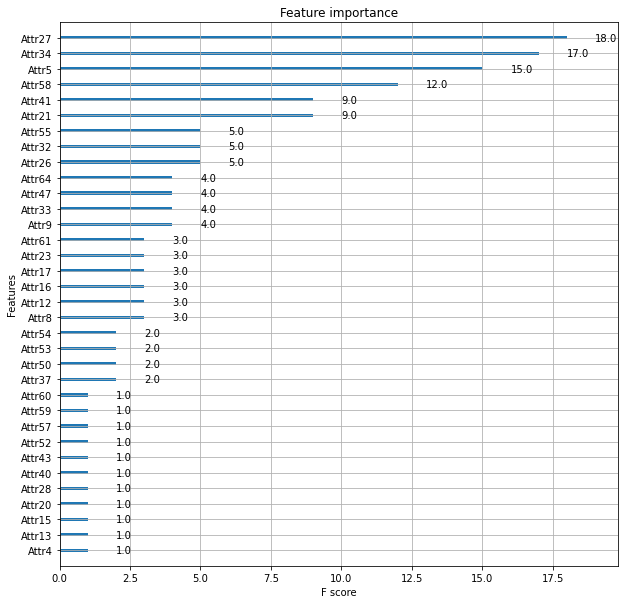

In [48]:
# Plot features
plt.rcParams["figure.figsize"] = (10,10)
xgboost.plot_importance(classifier.model._model)
# Show the plot
plt.show()

# Model Interpretability & Explainability <a id='model-explanation'>

Which variables were more important and why?

How did you come to the conclusion these variables were important how how should the audience interpret this?

## Examining Feature Importance <a id='examining-feature-importance'/>

# Conclusion <a id='conclusion'>

What are you proposing to the audience with your models and why?

How should your audience interpret your conclusion and whwere should they go moving forward on the topic?

What other approaches do you recommend exploring?

Bring it all home!

### Final Model Proposal <a id='final-model-proposal'/>

### Future Considerations and Model Enhancements <a id='model-enhancements'/>

### Alternative Modeling Approaches <a id='alternative-modeling-approaches'>

# References

Reference : 

[1] Bankruptcy Definition (investopedia.com)

[2] Ensemble boosted trees with synthetic features generation in application to bankruptcy prediction - ScienceDirect

[3] UCI Machine Learning Repository: Polish companies bankruptcy data Data Set


